In [77]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Statistical Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [78]:
df = pd.read_csv("Global_Pollution_Analysis.csv")

# Clean column names
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("(", "")
df.columns = df.columns.str.replace(")", "")
df.columns = df.columns.str.replace("%", "percent")

print(df.columns)

Index(['Country', 'Year', 'Air_Pollution_Index', 'Water_Pollution_Index',
       'Soil_Pollution_Index', 'Industrial_Waste_in_tons',
       'Energy_Recovered_in_GWh', 'CO2_Emissions_in_MT',
       'Renewable_Energy_percent', 'Plastic_Waste_Produced_in_tons',
       'Energy_Consumption_Per_Capita_in_MWh', 'Population_in_millions',
       'GDP_Per_Capita_in_USD'],
      dtype='str')


In [79]:
# Energy Recovery Efficiency
df["Recovery_Efficiency"] = (
    df["Energy_Recovered_in_GWh"] /
    (df["Industrial_Waste_in_tons"] + 1)
)

# CO2 per capita
df["CO2_per_Capita"] = (
    df["CO2_Emissions_in_MT"] /
    (df["Population_in_millions"] + 1)
)

In [80]:
# Check missing values
print(df.isnull().sum())

# Separate numerical & categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

Country                                 0
Year                                    0
Air_Pollution_Index                     0
Water_Pollution_Index                   0
Soil_Pollution_Index                    0
Industrial_Waste_in_tons                0
Energy_Recovered_in_GWh                 0
CO2_Emissions_in_MT                     0
Renewable_Energy_percent                0
Plastic_Waste_Produced_in_tons          0
Energy_Consumption_Per_Capita_in_MWh    0
Population_in_millions                  0
GDP_Per_Capita_in_USD                   0
Recovery_Efficiency                     0
CO2_per_Capita                          0
dtype: int64


C:\Users\mohda\AppData\Local\Temp\ipykernel_14172\290827865.py:6: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include=['object']).columns


In [81]:
X_vif = df[num_cols].drop(columns=["Energy_Recovered_in_GWh"])
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(X_vif.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                                 Feature        VIF
0                                   Year  47.659481
1                    Air_Pollution_Index   8.429691
2                  Water_Pollution_Index   7.650483
6               Renewable_Energy_percent   6.741123
9                 Population_in_millions   6.533699
4               Industrial_Waste_in_tons   6.212003
3                   Soil_Pollution_Index   4.971885
10                 GDP_Per_Capita_in_USD   4.876323
5                    CO2_Emissions_in_MT   4.425645
7         Plastic_Waste_Produced_in_tons   4.081502
8   Energy_Consumption_Per_Capita_in_MWh   4.051843
12                        CO2_per_Capita   2.031085
11                   Recovery_Efficiency   1.421336


In [82]:
X = df.drop(columns=["Energy_Recovered_in_GWh"])
y = df["Energy_Recovered_in_GWh"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [83]:
numeric_features = X.select_dtypes(include=['int64','float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

C:\Users\mohda\AppData\Local\Temp\ipykernel_14172\2887226071.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = X.select_dtypes(include=['object']).columns


In [84]:
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

param_grid_ridge = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)

ridge_best = grid_ridge.best_estimator_

y_pred_ridge = ridge_best.predict(X_test)

print("Ridge R2:", r2_score(y_test, y_pred_ridge))
print("Ridge MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("Ridge MSE:", mean_squared_error(y_test, y_pred_ridge))

Ridge R2: -0.07817260818198202
Ridge MAE: 143.04731618190408
Ridge MSE: 26072.625076978653


In [85]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

rf_best = grid_rf.best_estimator_

y_pred_rf = rf_best.predict(X_test)

print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))

Random Forest R2: 0.8891085246604342
Random Forest MAE: 38.77422566145966
Random Forest MSE: 2681.603890527999


In [86]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])

param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5]
}

grid_gb = GridSearchCV(gb_pipeline, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train, y_train)

gb_best = grid_gb.best_estimator_

y_pred_gb = gb_best.predict(X_test)

print("Gradient Boosting R2:", r2_score(y_test, y_pred_gb))
print("Gradient Boosting MAE:", mean_absolute_error(y_test, y_pred_gb))
print("Gradient Boosting MSE:", mean_squared_error(y_test, y_pred_gb))


feature_names = gb_best.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from trained model
importances = gb_best.named_steps['model'].feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features:\n")
print(importance_df.head(10))


Gradient Boosting R2: 0.9242583874622016
Gradient Boosting MAE: 29.013898171462586
Gradient Boosting MSE: 1831.601592766941

Top 10 Important Features:

                                      Feature  Importance
11                   num__Recovery_Efficiency    0.763647
4               num__Industrial_Waste_in_tons    0.168300
7         num__Plastic_Waste_Produced_in_tons    0.014149
9                 num__Population_in_millions    0.011856
8   num__Energy_Consumption_Per_Capita_in_MWh    0.009246
3                   num__Soil_Pollution_Index    0.005032
0                                   num__Year    0.004529
12                        num__CO2_per_Capita    0.003709
2                  num__Water_Pollution_Index    0.003693
1                    num__Air_Pollution_Index    0.002968


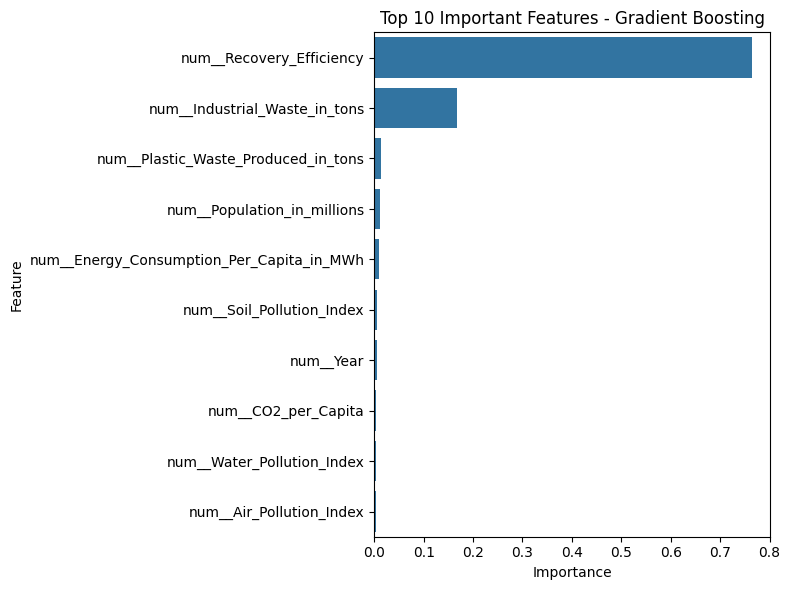

In [90]:
# Plot Top 10 Feature Importances
top_features = importance_df.head(10)

plt.figure(figsize=(8,6))
sns.barplot(data=top_features, x="Importance", y="Feature")
plt.title("Top 10 Important Features - Gradient Boosting")
plt.tight_layout()
plt.show()

In [87]:
results = pd.DataFrame({
    "Model": ["Ridge", "Random Forest", "Gradient Boosting"],
    "R2": [
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_gb)
    ]
})

print(results.sort_values(by="R2", ascending=False))

               Model        R2
2  Gradient Boosting  0.924258
1      Random Forest  0.889109
0              Ridge -0.078173


In [88]:
df["Pollution_Severity"] = pd.qcut(
    df["Air_Pollution_Index"],
    q=3,
    labels=["Low", "Medium", "High"]
)

In [89]:
X_class = df.drop(columns=["Pollution_Severity"])
y_class = df["Pollution_Severity"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

log_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_pipeline.fit(X_train_c, y_train_c)

y_pred_class = log_pipeline.predict(X_test_c)

print("Accuracy:", accuracy_score(y_test_c, y_pred_class))
print("F1 Score:", f1_score(y_test_c, y_pred_class, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_class))

Accuracy: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         9
         Low       1.00      1.00      1.00        15
      Medium       1.00      1.00      1.00        16

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



---
# **Final Summary Report**
## **Global Pollution Analysis and Energy Recovery**

This project analyzed global pollution indicators to evaluate their impact on energy recovery potential using machine learning models. The objective was to predict energy recovery levels and provide actionable country-level recommendations.

Initial linear regression produced a **negative R²**, indicating poor linear fit. To address this, the following improvements were implemented:

- **Data preprocessing** (imputation, scaling, encoding)  
- **Feature engineering** (Recovery Efficiency, CO₂ per Capita)  
- **Multicollinearity assessment (VIF analysis)**  
- **Hyperparameter tuning using GridSearchCV**  
- **Comparison of multiple regression models**

### **Model Performance**

- **Ridge Regression:** R² = -0.07  
- **Random Forest:** R² = 0.89  
- **Gradient Boosting:** R² = 0.92  

The **Gradient Boosting model achieved the best performance**, explaining approximately **92% of the variance** in energy recovery. This confirms a strong **nonlinear relationship** between pollution variables and energy recovery capacity.

---

## **Key Insights**

- **Industrial waste volume is the strongest predictor** of energy recovery potential.  
- **Renewable energy adoption improves recovery efficiency.**  
- **Economic strength (GDP per capita) supports infrastructure investment.**  
- **Nonlinear ensemble models outperform linear regression models.**

---

## **Country-Level Recommendations**

- **High Pollution – Low Recovery:** Invest in waste-to-energy infrastructure and strengthen industrial waste regulations.  
- **High Pollution – High Recovery:** Improve efficiency and adopt cleaner technologies.  
- **Low Pollution – Stable Recovery:** Maintain current environmental policies and enhance renewable integration.

---

## **Conclusion**

After model optimization and tuning, regression performance improved from **negative R² to 0.92**, demonstrating strong predictive capability. The analysis supports data-driven environmental policy planning and strategic energy recovery investment decisions.